# <center>MNIST Handwritten Digit Recognizer w/ TensorFlow NN</center>

In [34]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from sklearn.model_selection import KFold

# Data Preparation
To start, we load the MNIST data using TensorFlow. There are 60,000 training data samples and 10,000 data samples. Each sample is a 28x28 matrix of ints representing the grayscale value of each pixel in the image.

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# reshape to have a depth of 1
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
# reshape labels to be one-hot encoded arrays
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [25]:
print('Num training data:', len(x_train))
print('Num test data:', len(x_test))
print('Data shape:', x_train[0].shape)
print('Label shape:', y_train[0].shape)
x_train

Num training data: 60000
Num test data: 10000
Data shape: (28, 28, 1)
Label shape: (10,)


array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


We can see what each sample looks like using plt.imshow()

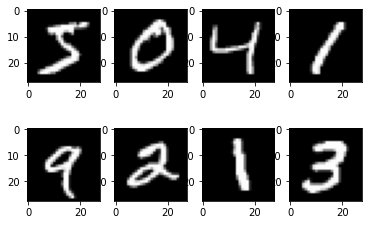

In [4]:
for i in range(2):
    for j in range(4):
        plt.subplot(2, 4, 4*i+j + 1)
        plt.imshow(x_train[4*i+j], cmap='gray')

# Data Preprocessing
Before using the data we need to scale it to make each gradient step consistent and thus allow our model to converge more quickly towards the minima. Since our data does not follow a Gaussian distribution I will use normalization to scale our data. More information about feature scaling an which method to use can be found here: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

In [5]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# Modeling

To start off as a baseline I will create a model equivalent to the one created from scratch so we will use SGD as the optimizer and sigmoid activation functions for hidden layers and softmax for the output layer. We use a Flatten layers for the input layer since we do not want our sample data to be in a grid as it is now but rather 'flat' AKA an array of $28 * 28 = 784$ values. Dense layers are your typical connected NN layers. 

In [24]:
nn = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation=tf.keras.activations.sigmoid),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

opt = tf.keras.optimizers.SGD()
loss = tf.keras.losses.MSE

nn.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

nn.fit(x_train, y_train, epochs=30, batch_size=10, validation_data=(x_test, y_test))

Epoch 1/30
6000/6000 [==============================] - 3s 582us/step - loss: 0.0732 - accuracy: 0.4655 - val_loss: 0.0591 - val_accuracy: 0.6415
Epoch 2/30
6000/6000 [==============================] - 3s 553us/step - loss: 0.0515 - accuracy: 0.7092 - val_loss: 0.0441 - val_accuracy: 0.7590
Epoch 3/30
6000/6000 [==============================] - 3s 543us/step - loss: 0.0400 - accuracy: 0.7775 - val_loss: 0.0352 - val_accuracy: 0.8057
Epoch 4/30
6000/6000 [==============================] - 3s 552us/step - loss: 0.0332 - accuracy: 0.8159 - val_loss: 0.0296 - val_accuracy: 0.8468
Epoch 5/30
6000/6000 [==============================] - 3s 547us/step - loss: 0.0286 - accuracy: 0.8494 - val_loss: 0.0262 - val_accuracy: 0.8661
Epoch 6/30
6000/6000 [==============================] - 3s 552us/step - loss: 0.0254 - accuracy: 0.8653 - val_loss: 0.0236 - val_accuracy: 0.8724
Epoch 7/30
6000/6000 [==============================] - 3s 563us/step - loss: 0.0232 - accuracy: 0.8721 - val_loss: 0.0217 -

I will attempt to improve this model and explore other learning techniques.  
  
For the activation function of the output layer it should be kept the same (softmax) but for the hidden layers I will choose the ReLU function as it does not suffer from the vanishing gradient problem that may occur when using the sigmoid or tanh functions. Additionally, the ReLU function is more computationally efficient than the sigmoid and tnah functions since it will only ause certain neurons to be activated. ReLU has been known to be a great general activation in most cases and can be use to start off with before switching to other activation functions if it does not produce optimal results.

Since this is a multi-class classification problem a loss function such as categorical cross entropy would be best suited for this and becuase I one-hot encoded the labels we can use TensorFlow's categorical_crossentropy loss function (TensorFlow's sparse categorical cross entropy loss function can be used when labels are ints).

I don't have much understanding about this optimizer but the Adam optimizer seems to be default "go-to" optimizer like the ReLU function is for loss functions. It seems that the Adam optimizer it a mix of gradient descent with momentum plus ADAGRAD optimization. In GD w/momemtum we update the parameters by an additional amount based off the previous update times some constant 'velocity'. ADAGRAD on ther other hand updates the learning rate by some amount based off the previous gradient.

I will be evaluating these models using 5-fold cross validation.

In [149]:
def evaluate_model_cv(X, Y, nfolds=5):
    scores, histories = [], []
    kfold = KFold(nfolds, shuffle=True, random_state=1)
    for tr_indices, va_indices in kfold.split(X,Y):
        xtr, ytr, xva, yva = X[tr_indices], Y[tr_indices], X[va_indices], Y[va_indices]
        model = build_model()
        history = model.fit(xtr, ytr, epochs=10, batch_size=30, validation_data=(xva, yva), verbose=False)
        _, acc = model.evaluate(xva, yva, verbose=False)
        print(acc)
        scores.append(acc)
        histories.append(history)
    return scores, histories
    

In [138]:
def plot_history(histories):
    plt.figure(figsize=(10,10))
    for history in histories:
        plt.subplot(2, 1, 1)
        plt.title('Loss')
        plt.semilogy(history.history['loss'], 'b', label='trainging error')
        plt.semilogy(history.history['val_loss'], 'orange', label='test error')
        plt.subplot(2, 1, 2)
        plt.title('Accuracy')
        plt.plot(history.history['accuracy'], 'b', label='training accuracy')
        plt.plot(history.history['val_accuracy'], 'orange', label='test accuracy')
    plt.show()

In [173]:
def summarize_scores(scores):
    print(f'Accuracy: mean={np.mean(scores)} std={np.std(scores)} ')

In [150]:
def build_model():    
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(30, activation=tf.keras.activations.relu), # ReLU activation
        tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
    ])

    opt = tf.keras.optimizers.Adam() # Adam optimizer
    loss = tf.keras.losses.categorical_crossentropy # categorical cross entropy loss function

    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

scores1, histories1 = evaluate_model_cv(x_train, y_train, 5)

0.8870833516120911
0.8901666402816772
0.9054166674613953
0.925166666507721
0.9132500290870667


/Users/farel/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/farel/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


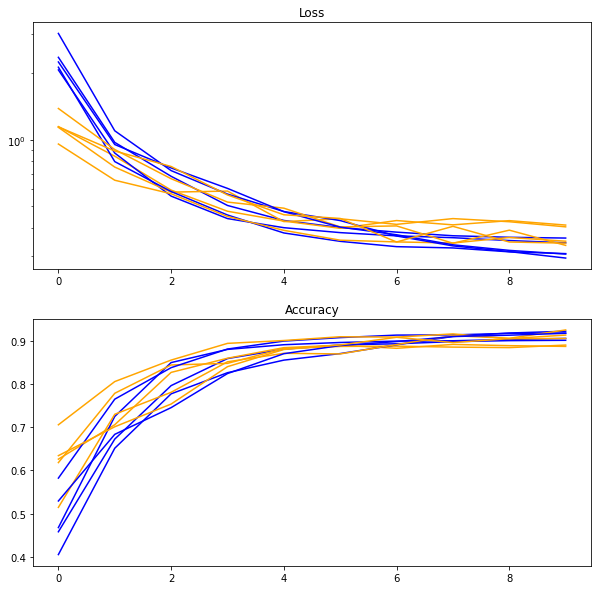

In [151]:
plot_history(histories1)

In [174]:
summarize_scores(scores1)

Accuracy: mean=0.9042166709899903 std=0.01423304505749891 


The model fits the data well and there no signs of over/underfitting with the training and validation loss plots converging. 

## Convolutional Neural Networks
Rather than flattening the input we can use convolutional layers to take in and pass along information. By flattening input we lose information about dependencies among pixels. For example, in the images we receive, the digits are more or less centered within the 28x28 image. If we received an image with a digit that was not centered or had other objects around it or in the background, the model probably would not be able to correctly classify it. Convolutional layers can capture the spatial dependencies that a flattened layer cannot.
  
A convolutional layer works by sliding a filter over each section of the image and applying it onto those sections by performing a hadamard (element-wise) product with it. These filters try to select parts of the image that provide relevant information to make a prediction and are learned parameters like the weights and biases in a neuron. Max pooling works by splitting the image into the pool-size and taking the max value out of that pool. This enhances certain features and reduces noise in the image.

In [160]:
def build_model():    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, input_shape=(28, 28, 1)), # convolutional layer
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
#         tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
    ])

    opt = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.categorical_crossentropy
    
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

    return model

scores3, histories3 = evaluate_model_cv(x_train, y_train, 5)

0.9774166941642761
0.9766666889190674
0.9740833044052124
0.9807500243186951
0.9785833358764648


/Users/farel/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/farel/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


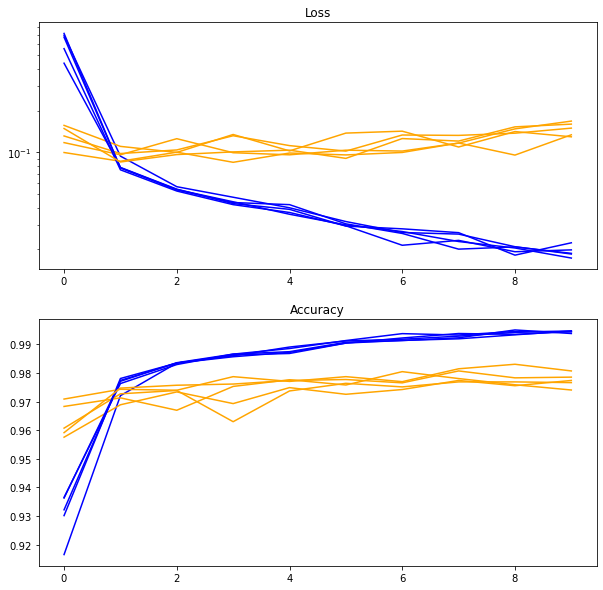

In [161]:
plot_history(histories3)

In [175]:
summarize_scores(scores3)

Accuracy: mean=0.9775000095367432 std=0.0021959704324148884 


The model generally fits the data pretty well having up to a 98% accuracy rate on validation data and it reduced the standard deviation of accuracy by about 0.01. However the cross validation plot shows signs of overfitting to training data as the error curves diverge. As training error generally decreases, the validation error generally increases.

# Avoiding Overfitting

To avoid overfitting I will introduce dropout and L2 regularization into the network. Dropout works by essentially disableing some neurons in the network at some given probability. L2 regularization reduces complexity by ensures no parameters get too big by penalizing greater parameter values in the loss function.

In [162]:
def build_model():    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, input_shape=(28, 28, 1)), # convolutional layer
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu, kernel_regularizer='l2'), # l2 regularization
        tf.keras.layers.Dropout(0.5), # introduce dropout layer at 0.5 dropout rate
        tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
    ])

    opt = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.categorical_crossentropy
    
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

    return model


dropout_reg_scores, dropout_reg_histories = evaluate_model_cv(x_train, y_train, 5)

0.9648333191871643
0.9574999809265137
0.971750020980835
0.9670000076293945
0.9659166932106018


/Users/farel/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/farel/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


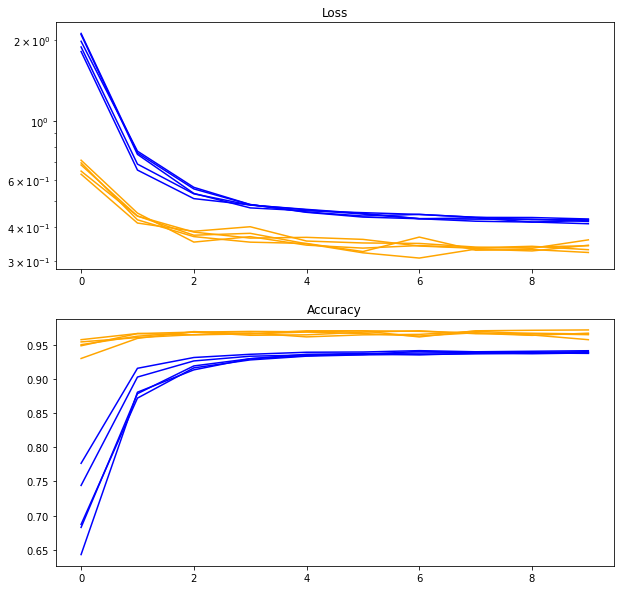

In [163]:
plot_history(dropout_reg_histories)

In [176]:
summarize_scores(dropout_reg_scores)

Accuracy: mean=0.9654000043869019 std=0.004601764688682693 


The model no longer overfits but the plots seem to imply that the model may now be too simple as loss and accuracy did not improve from the last model and stay relatively constant with further training epochs. We can fix this by reducing the dropout rate and/or increasing our model complexity by adding depth.

# Increasing Complexity

In [201]:
def build_model():    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, input_shape=(28, 28, 1)), 
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, input_shape=(28, 28, 1)), 
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, input_shape=(28, 28, 1)), 
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.keras.activations.relu, kernel_regularizer='l2'), 
        tf.keras.layers.Dropout(0.2), # lowered dropout rate 
        tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
    ])

    opt = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.categorical_crossentropy
    
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

    return model

inc_depth_scores, inc_depth_histories = evaluate_model_cv(x_train, y_train, 5)

0.9832500219345093
0.9860833287239075
0.9865833520889282
0.9853333234786987
0.9885833263397217


/Users/farel/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/farel/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


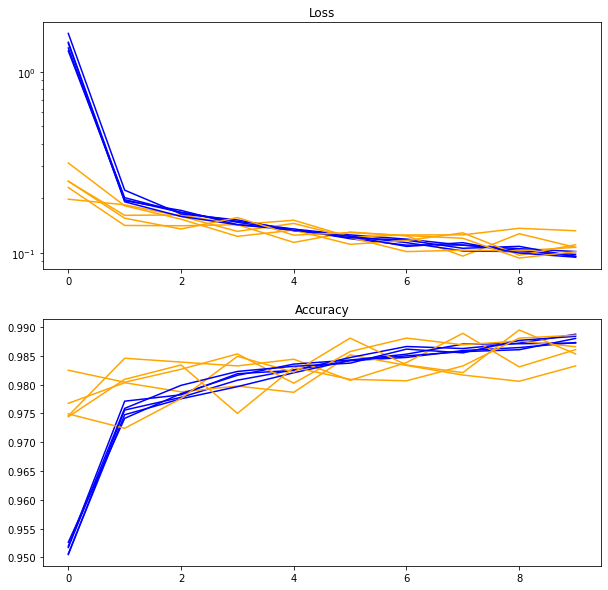

In [202]:
plot_history(inc_depth_histories)

In [203]:
summarize_scores(inc_depth_scores)

Accuracy: mean=0.9859666705131531 std=0.0017333263388440068 


This model performs very well on the training and validation data. There are no obvious signs of over or underfitting. There was an improvement in mean and standard deviation of accuracy.

# Final Model
Increase batch size for more accurate estimate of gradient step

In [216]:
# without data augmentation the model obtains a mid to high 98% accuracy
model = build_model()
final_history = model.fit(x_train, y_train, epochs=10, batch_size=86, validation_data=(x_test, y_test))

Epoch 1/10
698/698 [==============================] - 64s 92ms/step - loss: 2.5568 - accuracy: 0.9448 - val_loss: 0.7908 - val_accuracy: 0.9785
Epoch 2/10
698/698 [==============================] - 70s 100ms/step - loss: 0.4579 - accuracy: 0.9790 - val_loss: 0.2499 - val_accuracy: 0.9840
Epoch 3/10
698/698 [==============================] - 64s 91ms/step - loss: 0.1938 - accuracy: 0.9823 - val_loss: 0.1464 - val_accuracy: 0.9855
Epoch 4/10
698/698 [==============================] - 61s 87ms/step - loss: 0.1319 - accuracy: 0.9847 - val_loss: 0.1078 - val_accuracy: 0.9880
Epoch 5/10
698/698 [==============================] - 61s 88ms/step - loss: 0.1157 - accuracy: 0.9850 - val_loss: 0.1035 - val_accuracy: 0.9876
Epoch 6/10
698/698 [==============================] - 60s 87ms/step - loss: 0.1070 - accuracy: 0.9866 - val_loss: 0.1085 - val_accuracy: 0.9847
Epoch 7/10
698/698 [==============================] - 65s 94ms/step - loss: 0.1038 - accuracy: 0.9869 - val_loss: 0.1097 - val_accuracy

In [217]:
# using Data augmentation we can prevent overfitting and generalize our model better by training on transformed images
# on augmented data the model is able to achieve 99% accuracy
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)
final_history2 = model.fit(datagen.flow(x_train, y_train, batch_size=86), epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
698/698 [==============================] - 67s 96ms/step - loss: 0.1803 - accuracy: 0.9734 - val_loss: 0.1071 - val_accuracy: 0.9917
Epoch 2/10
698/698 [==============================] - 64s 92ms/step - loss: 0.1433 - accuracy: 0.9795 - val_loss: 0.1026 - val_accuracy: 0.9906
Epoch 3/10
698/698 [==============================] - 68s 98ms/step - loss: 0.1315 - accuracy: 0.9807 - val_loss: 0.1057 - val_accuracy: 0.9892
Epoch 4/10
698/698 [==============================] - 66s 95ms/step - loss: 0.1265 - accuracy: 0.9816 - val_loss: 0.0956 - val_accuracy: 0.9902
Epoch 5/10
698/698 [==============================] - 64s 92ms/step - loss: 0.1196 - accuracy: 0.9826 - val_loss: 0.0853 - val_accuracy: 0.9918
Epoch 6/10
698/698 [==============================] - 64s 92ms/step - loss: 0.1205 - accuracy: 0.9817 - val_loss: 0.0987 - val_accuracy: 0.9901
Epoch 7/10
698/698 [==============================] - 66s 94ms/step - loss: 0.1144 - accuracy: 0.9831 - val_loss: 0.0886 - val_accuracy:

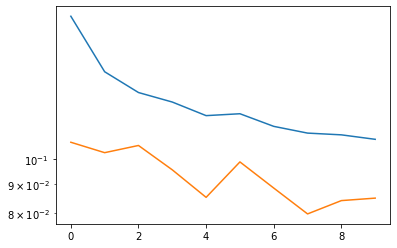

In [219]:
plt.semilogy(final_history2.history['loss'])
plt.semilogy(final_history2.history['val_loss'])

In [220]:
model.save('final_model.h5')